# Decision Dependent Games Simulation
## Uber vs. Lyft

We introduce fictional performative effects on top of real data scraped from Uber and Lyft to simulate a decision dependent risk minimization game.

In [1]:
import math
import numpy as np
import pandas as pd
import sys
import datetime

sys.path.append("../utils/")
from utils_rideshare import *

from dd_game_rideshare import *
from two_stage_player_rideshare import *
from dfo_player_rideshare import *

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import seaborn as sns
sns.set_style('darkgrid')

from tqdm import tqdm, trange
tqdm.pandas()

C:\Users\evanj\anaconda3\lib\site-packages\tqdm\std.py:697: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [2]:
rides = pd.read_csv('../data/rideshare_kaggle.csv')
rides['date'] = rides.progress_apply(lambda row: datetime.datetime.strptime(row['datetime'], '%Y-%m-%d %H:%M:%S').date(), axis=1)

new_rides = rides[['hour','cab_type','price','distance','date']].dropna(subset = ['price']).reset_index()
new_rides['distance'] = new_rides.progress_apply(lambda row: math.ceil(row['distance']), axis=1)
new_rides['price'] = new_rides.progress_apply(lambda row: 5*math.floor(row['price']/5), axis=1)

cab_types_ = new_rides.cab_type.unique()
distances_ = new_rides.distance.unique()
hours_ = np.array([17,18,19])  # new_rides.hour.unique()
prices_ = np.array([10])# np.array([5*(i) for i in range(5)])  # new_rides.price.unique()
dates = len(new_rides.date.unique())

g = np.zeros((len(cab_types_),len(prices_),len(hours_),len(distances_)))

for i in range(len(cab_types_)):
    for j in trange(len(prices_)):
        for k in range(len(hours_)):
            for m in range(len(distances_)):
                g[i,j,k,m] = len(new_rides[(new_rides['cab_type']==cab_types_[i])
                                          &(new_rides['price']==prices_[j])
                                          &(new_rides['hour']==hours_[k])
                                          &(new_rides['distance']==distances_[m])])/dates

np.random.seed(37)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.02s/it]


# Configurations

In [3]:
x = [17,2]  # [time, distance]
g_uber = g[np.where(cab_types_=='Uber'),:,np.where(hours_==x[0]),np.where(distances_==x[1])].reshape((-1,1))
g_lyft = g[np.where(cab_types_=='Lyft'),:,np.where(hours_==x[0]),np.where(distances_==x[1])].reshape((-1,1))

prices_ = prices_.reshape((-1,1))

print(f'g_uber = \n{g_uber}')
print(f'g_lyft = \n{g_lyft}')

d_1 = len(g_uber)  # Dimension of each player's data/strategy
d_2 = len(g_lyft)

lambda_p1 = 1e-3
lambda_p2 = 1e-3

eta_p1 = 1e-3
eta_p2 = 1e-3

mu_p1 = -0.1*g_uber
gamma_p1 = 0.05*g_uber
mu_p2 = -0.1*g_lyft
gamma_p2 = 0.05*g_lyft

g_uber = 
[[52.11764706]]
g_lyft = 
[[76.64705882]]


In [4]:
p1_data_params = (g_uber, d_1, mu_p1, gamma_p1, lambda_p1, eta_p1, prices_)
p1_data_generating_func = sample_from_location_family_rideshare

p2_data_params = (g_lyft, d_2, mu_p2, gamma_p2, lambda_p2, eta_p2, prices_)
p2_data_generating_func = sample_from_location_family_rideshare

In [5]:
num_rounds_lst = np.logspace(1,5,5,dtype='int')
num_test = 10000
num_alternate_rounds = 1000

# Run game with 2-stage algorithm

In [6]:
p1_risks = []
p2_risks = []
theta_final_p1 = []
theta_final_p2 = []

for num_rounds in num_rounds_lst:
    print(f"num_rounds = {num_rounds}")
    player_one = TwoStagePlayer()
    player_two = TwoStagePlayer()
    game_ts = DecisionDependentGame(player_one, player_two,
                                    p1_data_params, p2_data_params,
                                    p1_data_generating_func, p2_data_generating_func,
                                    num_rounds, num_alternate_rounds, num_test)
    
    game_ts.run_train()
    game_ts.run_post_train_alternating()
    
    PR1 = game_ts.evaluate_perf_risk_p1()
    PR2 = game_ts.evaluate_perf_risk_p2()
    
    p1_risks.append(PR1)
    p2_risks.append(PR2)
    
    theta_final_p1.append(game_ts.theta_p1)
    theta_final_p2.append(game_ts.theta_p2)
    
    #Change this flag if one wants to change print settings
    if True:
        print("---------------------")
        print("Player 1: mu error")
        print(np.linalg.norm(mu_p1-player_one.mu_hat))
        print("Player 1: gamma error")
        print(np.linalg.norm(gamma_p1-player_one.gamma_hat))
        print("Player 1 Risk:")
        print(PR1)

        print("Player 2: mu error")
        print(np.linalg.norm(mu_p2-player_two.mu_hat))
        print("Player 2: gamma error")
        print(np.linalg.norm(gamma_p2-player_two.gamma_hat))
        print("Player 2 Risk:")
        print(PR2)
        print("---------------------")

num_rounds = 10
---------------------
Player 1: mu error
17.078038354188116
Player 1: gamma error
1.9566204869927932
Player 1 Risk:
-620.7154029104302
Player 2: mu error
4.256351973821822
Player 2: gamma error
9.451859245139204
Player 2 Risk:
-26.23461697027161
---------------------
num_rounds = 100
---------------------
Player 1: mu error
1.6549112493432556
Player 1: gamma error
1.4942626428823265
Player 1 Risk:
-549.7503041391116
Player 2: mu error
1.9052208330069984
Player 2: gamma error
0.3462874099096176
Player 2 Risk:
-716.5627543323336
---------------------
num_rounds = 1000
---------------------
Player 1: mu error
0.6294940543901264
Player 1: gamma error
0.6334843402640611
Player 1 Risk:
-511.55034264064597
Player 2: mu error
0.25559853872617744
Player 2: gamma error
0.07717954592680432
Player 2 Risk:
-744.4618819963356
---------------------
num_rounds = 10000
---------------------
Player 1: mu error
0.06049760894992051
Player 1: gamma error
0.06839691778266133
Player 1 Risk:
-

# Run game with DFO players

In [8]:
p3_risks = []
p4_risks = []
theta_final_p3 = []
theta_final_p4 = []

delta = 1
eta = 1e-3
num_test_dfo = 1
num_rounds = num_rounds_lst[-1]
batch_size = 1

player_three = DFOPlayer(delta,eta)
player_four = DFOPlayer(delta,eta)
game_dfo = DecisionDependentGame(player_three, player_four,
                                 p1_data_params, p2_data_params,
                                 p1_data_generating_func, p2_data_generating_func,
                                 num_test_dfo)

for i in trange(num_rounds+1):
    PR_3_oracle = []
    PR_4_oracle = []
    for j in range(batch_size):
        game_dfo.theta_p1 = player_three.perturb_theta()
        game_dfo.theta_p2 = player_four.perturb_theta()

        PR_3_oracle.append(game_dfo.evaluate_perf_risk_p1())
        PR_4_oracle.append(game_dfo.evaluate_perf_risk_p2())
    
    game_dfo.theta_p1 = player_three.update_theta(PR_3_oracle)
    game_dfo.theta_p2 = player_four.update_theta(PR_4_oracle)
    
    if i in num_rounds_lst:
        p3_risks.append(evaluate_performative_risk(p1_data_generating_func, g_uber, prices_,
                                                   mu_p1, gamma_p1,
                                                   lambda_p1,
                                                   game_dfo.theta_p1, game_dfo.theta_p2,
                                                   num_test))
        p4_risks.append(evaluate_performative_risk(p2_data_generating_func, g_lyft, prices_,
                                                   mu_p2, gamma_p2,
                                                   lambda_p2,
                                                   game_dfo.theta_p2, game_dfo.theta_p1,
                                                   num_test))
        
        theta_final_p3.append(game_dfo.theta_p1)
        theta_final_p4.append(game_dfo.theta_p2)
    
        if True:
            print("---------------------")
            print(f"Iteration {i}")
            print("Player 3 risk:")
            print(p3_risks[-1])

            print("Player 4 risk:")
            print(p4_risks[-1])
            print("---------------------")
            
# print(np.mean(game_dfo.p1.theta_history))
# print(np.mean(game_dfo.p2.theta_history))
# theta_final_p3[-1] = np.mean(game_dfo.p1.theta_history)
# theta_final_p4[-1] = np.mean(game_dfo.p2.theta_history)

  0%|▎                                                                          | 393/100001 [00:00<00:52, 1891.18it/s]

---------------------
Iteration 10
Player 3 risk:
-447.09074299439675
Player 4 risk:
-786.773649867131
---------------------
---------------------
Iteration 100
Player 3 risk:
-381.0837441042965
Player 4 risk:
-483.2154410411388
---------------------


  1%|▉                                                                         | 1314/100001 [00:00<00:45, 2180.88it/s]

---------------------
Iteration 1000
Player 3 risk:
-393.26060894080143
Player 4 risk:
-570.6290978537679
---------------------


 10%|███████▌                                                                 | 10277/100001 [00:03<00:29, 2997.73it/s]

---------------------
Iteration 10000
Player 3 risk:
-738.6039265186142
Player 4 risk:
-529.0907656533101
---------------------


100%|████████████████████████████████████████████████████████████████████████| 100001/100001 [00:36<00:00, 2723.42it/s]

---------------------
Iteration 100000
Player 3 risk:
-387.3401929086318
Player 4 risk:
-617.7526791357583
---------------------


## Plots

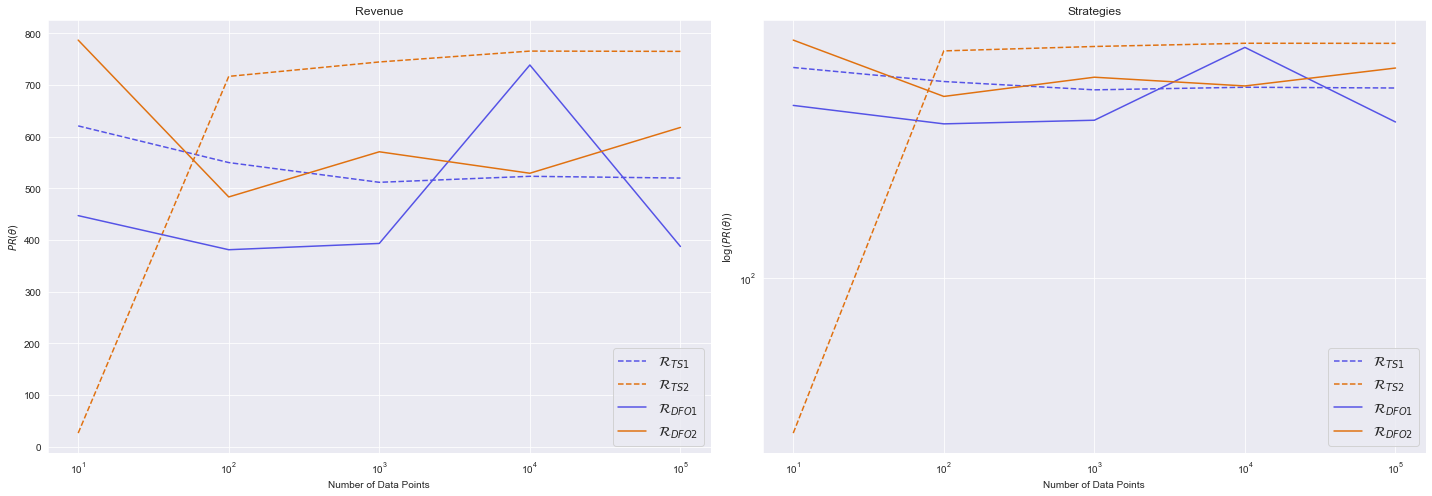

In [9]:
plt.figure(figsize=(20,7))
plt.subplot(1,2,1)
plt.semilogx(num_rounds_lst, -np.squeeze(p1_risks),
             '--', color='#5553E6', label=r'$\mathcal{R}_{TS1}$')
plt.semilogx(num_rounds_lst, -np.squeeze(p2_risks),
             '--', color='#E07110', label=r'$\mathcal{R}_{TS2}$')

plt.semilogx(num_rounds_lst, -np.squeeze(p3_risks),
             '-', color='#5553E6', label=r'$\mathcal{R}_{DFO1}$')
plt.semilogx(num_rounds_lst, -np.squeeze(p4_risks),
             '-', color='#E07110', label=r'$\mathcal{R}_{DFO2}$')

plt.xlabel("Number of Data Points")
plt.ylabel(r"$PR(\theta)$")
plt.title("Revenue")
plt.legend(fontsize=14)

plt.subplot(1,2,2)
plt.loglog(num_rounds_lst, -np.squeeze(p1_risks),
           '--', color='#5553E6', label=r'$\mathcal{R}_{TS1}$')
plt.loglog(num_rounds_lst, -np.squeeze(p2_risks),
           '--', color='#E07110', label=r'$\mathcal{R}_{TS2}$')

plt.loglog(num_rounds_lst, -np.squeeze(p3_risks),
           '-', color='#5553E6', label=r'$\mathcal{R}_{DFO1}$')
plt.loglog(num_rounds_lst, -np.squeeze(p4_risks),
           '-', color='#E07110', label=r'$\mathcal{R}_{DFO2}$')

plt.xlabel("Number of Data Points")
plt.ylabel(r"$\log(PR(\theta))$")
plt.title('Revenue')
plt.legend(fontsize=14)

# plt.subplot(1,3,3)
# plt.semilogx(num_rounds_lst, np.squeeze(theta_final_p1),
#            '--', color='#5553E6', label=r'$\theta_{TS1}$')
# plt.semilogx(num_rounds_lst, np.squeeze(theta_final_p2),
#            '--', color='#E07110', label=r'$\theta_{TS2}$')

# plt.semilogx(num_rounds_lst, np.squeeze(theta_final_p3),
#            '-', color='#5553E6', label=r'$\theta_{DFO1}$')
# plt.semilogx(num_rounds_lst, np.squeeze(theta_final_p4),
#            '-', color='#E07110', label=r'$\theta_{DFO2}$')

# plt.ylim(-10,10)
plt.xlabel("Number of Data Points")
plt.ylabel(r"$\log(PR(\theta))$")
plt.title('Strategies')
plt.legend(fontsize=14)
plt.tight_layout()
plt.savefig('DD_regression_rideshare_convergence.jpg', format='jpg')
plt.show()

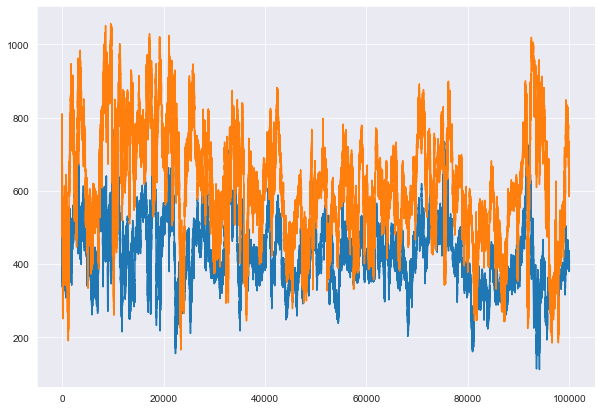

In [10]:
plt.figure(figsize=(10,7))
plt.plot(-np.squeeze(game_dfo.p1.risk_history))
plt.plot(-np.squeeze(game_dfo.p2.risk_history))
plt.show()

In [11]:
print(f'theta_1_ts - theta_1_dfo = \n{game_ts.theta_p1-game_dfo.theta_p1}')
print(f'theta_2_ts - theta_2_dfo = \n{game_ts.theta_p2-game_dfo.theta_p2}')

theta_1_ts - theta_1_dfo = 
[[-0.7921169]]
theta_2_ts - theta_2_dfo = 
[[4.62494477]]


In [12]:
print(f'theta_1_ts = \n{game_ts.theta_p1}')
print(f'theta_2_ts = \n{game_ts.theta_p2}')

theta_1_ts = 
[[-0.00171733]]
theta_2_ts = 
[[-0.01983596]]


In [13]:
print(f'theta_1_dfo = \n{game_dfo.theta_p1}')
print(f'theta_2_dfo = \n{game_dfo.theta_p2}')

theta_1_dfo = 
[[0.79039957]]
theta_2_dfo = 
[[-4.64478073]]


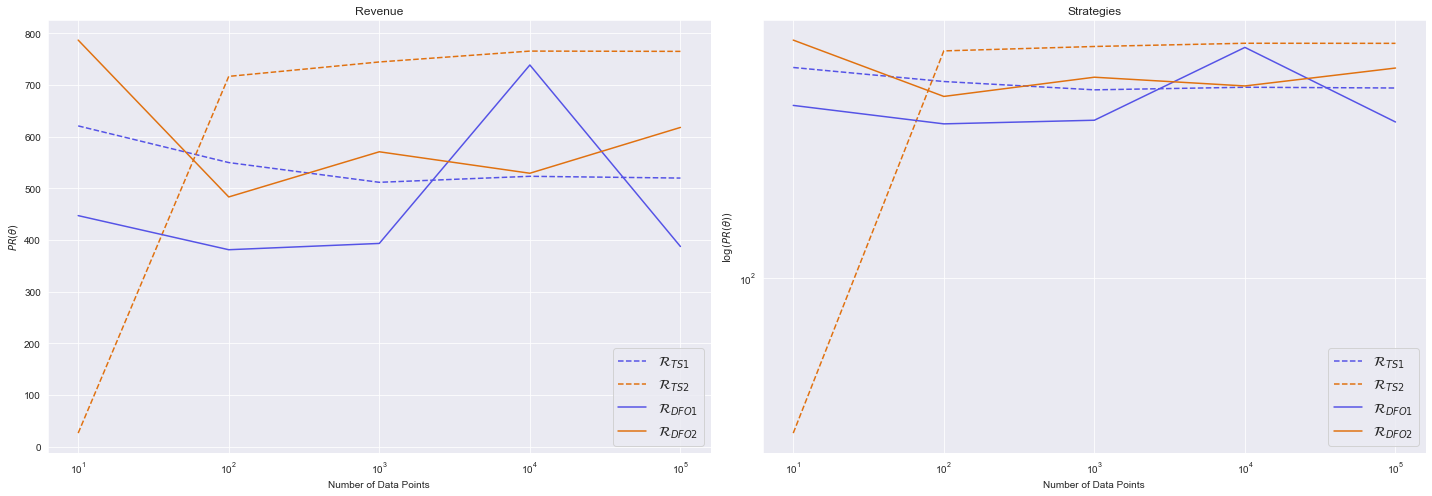

In [14]:
plt.figure(figsize=(20,7))
plt.subplot(1,2,1)
plt.semilogx(num_rounds_lst, -np.squeeze(p1_risks),
             '--', color='#5553E6', label=r'$\mathcal{R}_{TS1}$')
plt.semilogx(num_rounds_lst, -np.squeeze(p2_risks),
             '--', color='#E07110', label=r'$\mathcal{R}_{TS2}$')

plt.semilogx(num_rounds_lst, -np.squeeze(p3_risks),
             '-', color='#5553E6', label=r'$\mathcal{R}_{DFO1}$')
plt.semilogx(num_rounds_lst, -np.squeeze(p4_risks),
             '-', color='#E07110', label=r'$\mathcal{R}_{DFO2}$')

plt.xlabel("Number of Data Points")
plt.ylabel(r"$PR(\theta)$")
plt.title("Revenue")
plt.legend(fontsize=14)

plt.subplot(1,2,2)
plt.loglog(num_rounds_lst, -np.squeeze(p1_risks),
           '--', color='#5553E6', label=r'$\mathcal{R}_{TS1}$')
plt.loglog(num_rounds_lst, -np.squeeze(p2_risks),
           '--', color='#E07110', label=r'$\mathcal{R}_{TS2}$')

plt.loglog(num_rounds_lst, -np.squeeze(p3_risks),
           '-', color='#5553E6', label=r'$\mathcal{R}_{DFO1}$')
plt.loglog(num_rounds_lst, -np.squeeze(p4_risks),
           '-', color='#E07110', label=r'$\mathcal{R}_{DFO2}$')

plt.xlabel("Number of Data Points")
plt.ylabel(r"$\log(PR(\theta))$")
plt.title('Revenue')
plt.legend(fontsize=14)

# plt.subplot(1,3,3)
# plt.semilogx(num_rounds_lst, np.squeeze(theta_final_p1),
#            '--', color='#5553E6', label=r'$\theta_{TS1}$')
# plt.semilogx(num_rounds_lst, np.squeeze(theta_final_p2),
#            '--', color='#E07110', label=r'$\theta_{TS2}$')

# plt.semilogx(num_rounds_lst, np.squeeze(theta_final_p3),
#            '-', color='#5553E6', label=r'$\theta_{DFO1}$')
# plt.semilogx(num_rounds_lst, np.squeeze(theta_final_p4),
#            '-', color='#E07110', label=r'$\theta_{DFO2}$')

# plt.ylim(-10,10)
plt.xlabel("Number of Data Points")
plt.ylabel(r"$\log(PR(\theta))$")
plt.title('Strategies')
plt.legend(fontsize=14)
plt.tight_layout()
plt.savefig('DD_regression_rideshare_convergence.jpg', format='jpg')
plt.show()